In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import contractions
from bs4 import BeautifulSoup
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

import random
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rupak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rupak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rupak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\rupak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
test = "I can't do this anymore 1 <head> ?? I am running away now"
test= contractions.fix(test)
text = re.sub(r'[^\w\s!?]', ' ', test)
text = re.sub(r'\d', '', test)
print(text)

I cannot do this anymore  <head> ?? I am running away now


In [3]:
lemmatizer = WordNetLemmatizer()

# Function to map POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
# Define a custom lemmatizer to not lemmatize US
class CustomLemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.exceptions = {'us'}

    def lemmatize(self, word, pos='n'):
        # Check if the word is in exceptions
        if word in self.exceptions:
            return word
        # Otherwise, use the default lemmatizer
        return self.lemmatizer.lemmatize(word, pos)

#preprocessing function
def clean_data(data):
    #expand contractions
    text = contractions.fix(data)
    
    #remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    #remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    #remove numbers
    text = re.sub(r'[0-9]', '', text)

    #remove news reporters
    text = re.sub(r'\s*-\s*[^-]*$', '', text)
    
    #remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    #remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # tokenize text
    text_tokens = word_tokenize(text)

    #remove the word 'climate' and 'change' from the text
    text_tokens = [word for word in text_tokens if word.lower() not in ['climate', 'change']]
    
    #remove stopwords but keep 'not' and 'no'
    stop_words = set(stopwords.words('english'))
    stop_words.discard('no')  # Retain 'no'
    stop_words.discard('not')  # Retain 'not'
    stop_words.discard('out')  # Retain 'out'
    text_tokens = [word for word in text_tokens if word.lower() not in stop_words]
    
    #POS tagging
    pos_tags = pos_tag(text_tokens)
    
    #lemmatize based on POS and remove stopwords
    custom_lemmatizer = CustomLemmatizer()
    text = [
        custom_lemmatizer.lemmatize(word.lower(), get_wordnet_pos(pos))  # Lemmatize word based on POS #mexicos to mexico
        for word, pos in pos_tags 
        if len(word) > 1  # Ensure word length is >1 (remove single characters)
    ]
    
    #return the cleaned text
    return ' '.join(text)

#example use case
text = "Climate change is not a hoax. It is real and it is happening now. We must take action to stop it. The US is not doing enough to combat climate change. What else can we do?"
cleaned_text = clean_data(text)
print(cleaned_text)

not hoax real happening must take action stop us not enough combat else


In [4]:
# Example text
text = "The brazil is not doing enough to combat climate change."

# List of countries to remove
countries = ["usa", "us", "india", "germany", "brazil", "canada", "australia", "france", "mexico", "japan", "china","spain","italy","indian","south","korea","russia","uk","ukraine","global"
]

# Function to remove country names from text
def remove_countries(text, country_list):
   # Join the country list into a string with word boundaries (to ensure exact matches)
   country_pattern = r'\b(?:' + '|'.join(map(re.escape, country_list)) + r')\b'
   # Remove all matches (countries) from the text
   return re.sub(country_pattern, '', text, flags=re.IGNORECASE)

# Remove countries from the text
cleaned_text = remove_countries(text, countries)
print(cleaned_text)

The  is not doing enough to combat climate change.


In [5]:
#load data
df = pd.read_csv("climate_headlines_sentiment.csv")
print(df.shape)
df.head()

(1024, 6)


,Unnamed: 0,Headline,Link,Content,Sentiment,Justification
0,0,Australia's year ahead in climate and environm...,https://www.abc.net.au/news/science/2024-01-23...,The year has barely started and extreme weath...,0.0,The headline is unclear about its direct impac...
1,1,Projections reveal the vulnerability of freshw...,https://news.griffith.edu.au/2024/01/09/projec...,"“Water from groundwater, rivers and rainfall ...",-0.5,The vulnerability of freshwater is concerning ...
2,2,"Record heat in 2023 worsened global droughts, ...",https://www.anu.edu.au/news/all-news/record-he...,2023 saw an increase in the frequency and int...,-1.0,The headline describes worsening environmental...
3,3,"It's not just the total rainfall ""“ why is eas...",https://www.theguardian.com/australia-news/202...,The number of storms in some regions is decre...,0.0,The headline is unclear about its stance on cl...
4,4,Expert Commentary: 2023 was the warmest year o...,https://www.csiro.au/en/news/all/news/2024/jan...,The European Union's Copernicus Climate Chang...,-0.5,While highlighting the reality of climate chan...


In [6]:
#take the features and targets 
df = df[["Headline","Sentiment"]]
df.head()


,Headline,Sentiment
0,Australia's year ahead in climate and environm...,0.0
1,Projections reveal the vulnerability of freshw...,-0.5
2,"Record heat in 2023 worsened global droughts, ...",-1.0
3,"It's not just the total rainfall ""“ why is eas...",0.0
4,Expert Commentary: 2023 was the warmest year o...,-0.5


In [7]:
df["Cleaned Headline"] = df["Headline"].apply(clean_data)

#looking for nan values in the target column
for i in range(len(df)):
	if pd.isna(df.loc[i,"Sentiment"]):
		print(f'index {i} has nan value')

C:\Users\rupak\AppData\Local\Temp\ipykernel_23336\656724195.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


index 232 has nan value


In [8]:
print(df.loc[232,"Headline"])
#assigning correct sentiment value to the nan value
df.loc[232, "Sentiment"] = -1.0
print(df.loc[232,"Sentiment"])


label_mapping = {-1.0: 0, -0.5: 0, 0.0: 1, 0.5: 2, 1.0: 2}
# Replace the labels in the DataFrame
df['Int Sentiment'] = df['Sentiment'].replace(label_mapping)
# Change the data type of 'Int Sentiment' column to int
df['Int Sentiment'] = df['Int Sentiment'].astype(int)

Mexico City is running out of water, forcing many to ration - Axios
-1.0


In [9]:

x_data = df["Cleaned Headline"].apply(lambda text: remove_countries(text, countries))
y_data = df["Int Sentiment"]

# Split the data into training and remaining data (testing + validation)
#x_train, x_temp, y_train,  y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_val, y_train,  y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

#x_val, x_test, y_val,  y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Split the remaining data (temp_data) into validation and test sets
#x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Now you have:
# - train_data (80% of the original data)
# - val_data (10% of the original data)
# - test_data (10% of the original data)

print("Train shape: ",x_train.shape)
print("Val shape: ",x_val.shape)
#print("Test shape: ",x_test.shape)

Train shape:  (921,)
Val shape:  (103,)


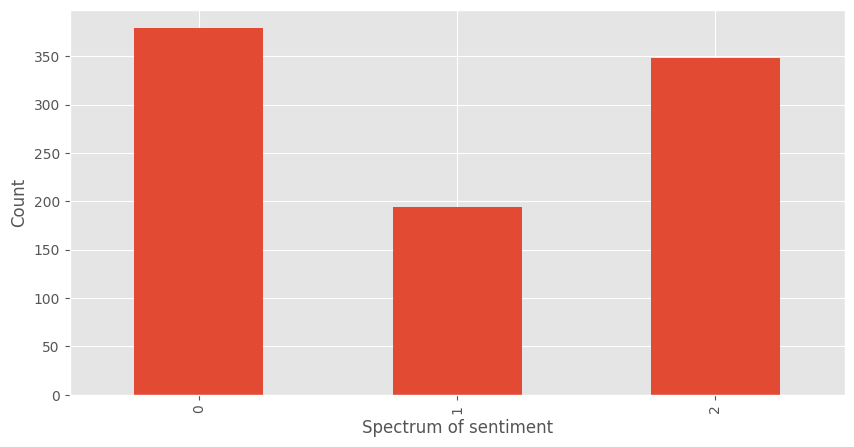

In [10]:
#Analyzing senntiment counts in training data
plt.style.use('ggplot')
ax = y_train.value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(10,5))
ax.set_xlabel('Spectrum of sentiment')
ax.set_ylabel('Count')
plt.show()

c:\Users\rupak\Videos\NLP\Lib\site-packages\numpy\lib\_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


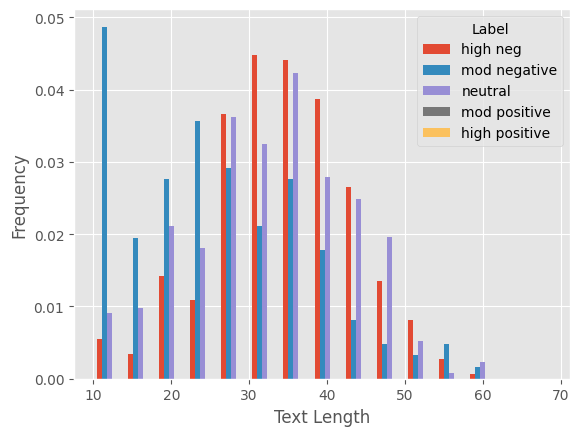

<Figure size 1000x500 with 0 Axes>

ValueError: max() arg is an empty sequence

In [11]:
# Create a list of lengths for training examples with a positive label.
text_lengths_high_pos = [len(text) for i, text in enumerate(x_train) if y_train.iloc[i]==4]
text_lengths_mod_pos = [len(text) for i, text in enumerate(x_train) if y_train.iloc[i]==3]
# And a list of lengths for training examples with a negative label.
text_lengths_high_neg =[len(text) for i, text in enumerate(x_train) if y_train.iloc[i]==0]
text_lengths_mod_neg = [len(text) for i, text in enumerate(x_train) if y_train.iloc[i]==1]
text_lengths_neutral = [len(text) for i, text in enumerate(x_train) if y_train.iloc[i]==2]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_high_neg, text_lengths_mod_neg, text_lengths_neutral, text_lengths_mod_pos, text_lengths_high_pos], bins=15, range=(10, 70), density=True,
         label=['high neg','mod negative', 'neutral','mod positive','high positive'])

plt.xlabel('Text Length')  # x-level
plt.ylabel('Frequency')  # y-level
plt.legend(title='Label')  # Overall legend
plt.figure(figsize=(10, 5))
plt.show()

# Also check the longest tweets.
print('longest high positive headline:', max(text_lengths_high_pos))
print('longest moderate positive headline:', max(text_lengths_mod_pos))
print('longest neutral headline:', max(text_lengths_neutral))
print('longest high negative headline:', max(text_lengths_high_neg))
print('longest moderate negative headline:', max(text_lengths_mod_neg))

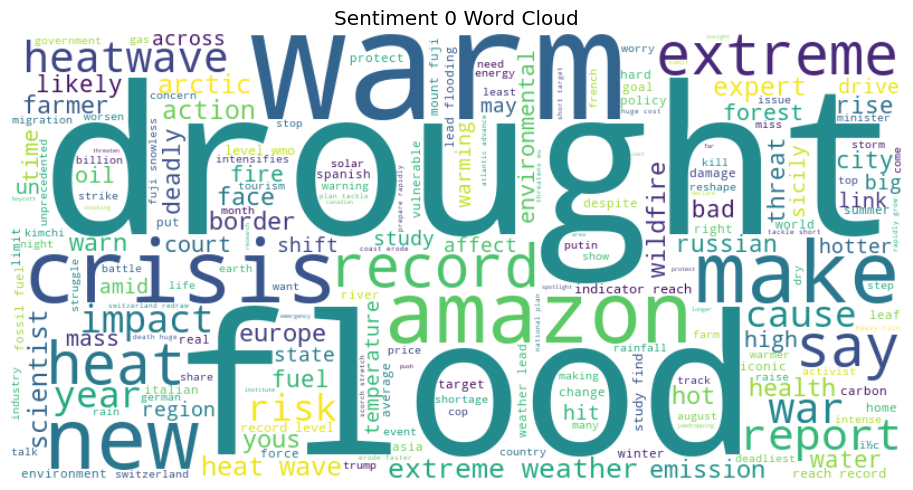

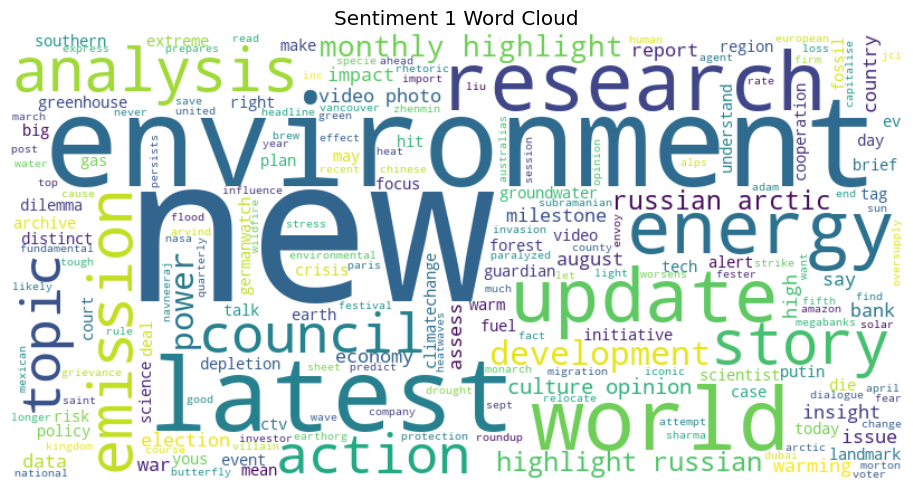

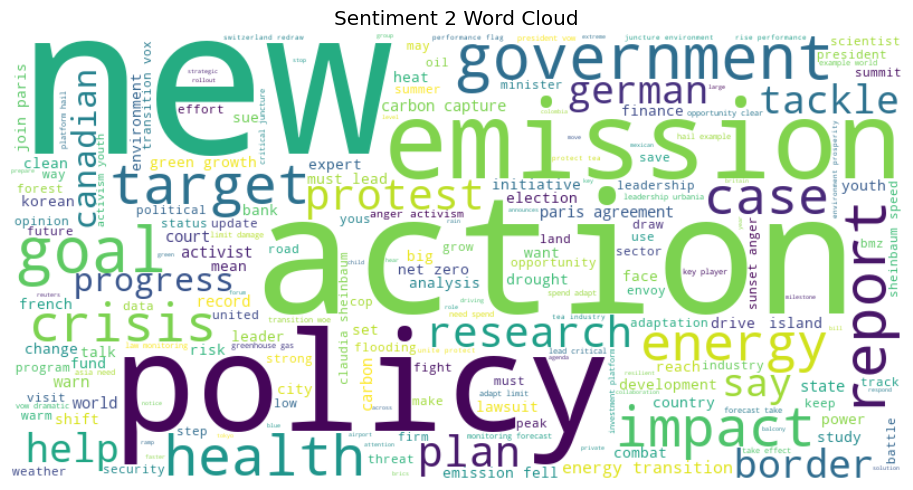

In [146]:
# Generate word clouds for each sentiment category
sentiment_categories = [0, 1, 2]
wordclouds = {}

for sentiment in sentiment_categories:
    text = " ".join(x_train[y_train == sentiment])
    wordclouds[sentiment] = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word clouds


for  sentiment in sentiment_categories:
    plt.figure(figsize=(10,5))
    plt.imshow(wordclouds[sentiment], interpolation='bilinear')
    plt.title(f'Sentiment {sentiment} Word Cloud')
    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [30]:
#function to get words frequency
def get_words_frequency(texts):
    word_frequency = Counter()
    for text in texts:
        words = text.split()
        word_frequency.update(words)
    return word_frequency #returns a dictionary with word frequencies

#function to get most common words
def sentiment_specific_common_words(texts,sentiments,sentiment_value,num_words=15):
    headlines = texts[sentiments == sentiment_value]
    word_frequency = get_words_frequency(headlines)
    most_common_words = word_frequency.most_common(num_words) #a list of tuples with word and frequency
    return zip(*most_common_words) # * unpacks the list into tuples; zip groups the first elements of each tuple together and the second elements together

#function to plot the bar chart for the most common words
def plot_words_frequency(texts, sentiments, sentiment_value, bar_color):
    words, frequencies = sentiment_specific_common_words(texts, sentiments, sentiment_value)
    #convert the tuples to lists for plotting
    words = list(words)
    frequencies = list(frequencies)
    #plot
    plt.figure(figsize=(6, 3))
    plt.bar(words, frequencies, color=bar_color)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Most Common Words in Sentiment {sentiment_value}')
    plt.xticks(rotation=45)
    plt.show()

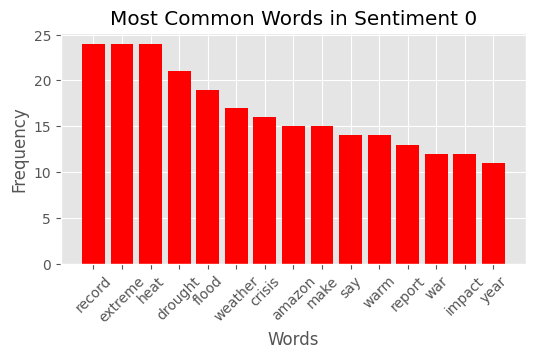

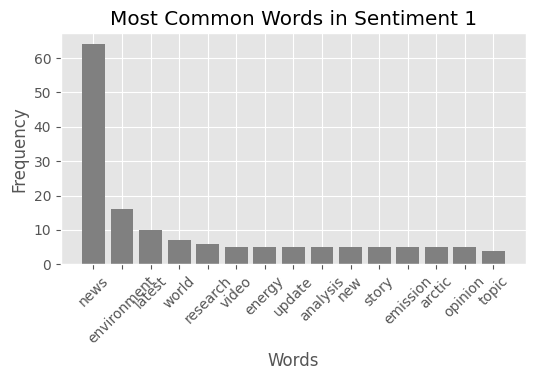

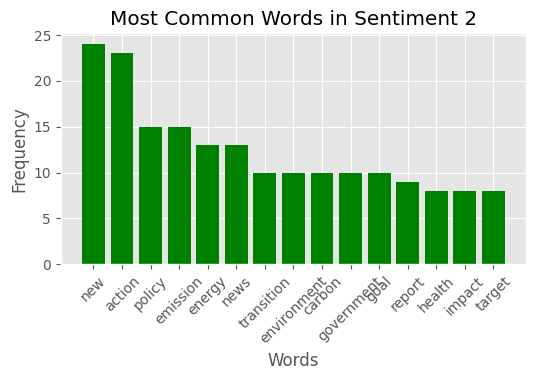

In [147]:
sentiment_colors = {
    0: 'red',          # High Negative
   # 1: 'lightcoral', # Moderate Negative
    1: 'gray',          # Neutral
    #3: 'lightgreen',  # Moderate Positive
    2: 'green'          # High Positive
}

for sentiment_value, color in sentiment_colors.items():
    plot_words_frequency(x_train, y_train, sentiment_value,color)


In [15]:
print(y_train[:10])

137    0
377    0
388    0
824    0
767    4
712    0
584    0
506    0
706    4
334    0
Name: Int Sentiment, dtype: int64


Train Accuracy: 0.21
Validation Accuracy: 0.16
Test Accuracy: 0.20
Train F1 Score: 0.21
Validation F1 Score: 0.16
Test F1 Score: 0.20


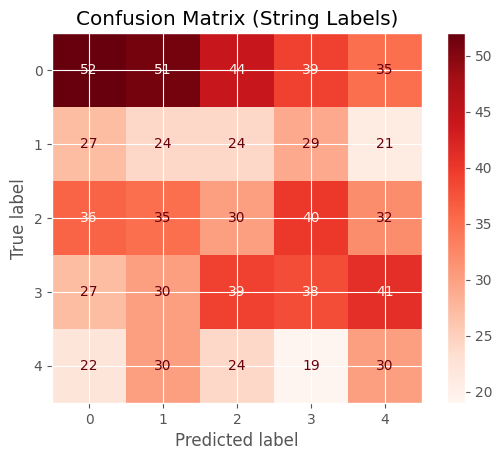

In [161]:
# Set a random seed for reproducibility
random.seed(42)

# Function to randomly assign one of the target values to each input
sentiment_categories = ['0','1','2', '3', '4']
#sentiment_categories = np.array(sentiment_categories, dtype=np.float64)

def random_baseline_model(num_samples):
    return [random.choice(sentiment_categories) for _ in range(num_samples)]


#convert traget labels (sentiments) to string (otherwise continuous value error will be encountered)
y_train_str = y_train.astype(str)
y_val_str = y_val.astype(str)
y_test_str = y_test.astype(str)

#model predictions
y_train_pred = random_baseline_model(len(y_train_str))
y_val_pred = random_baseline_model(len(y_val))
y_test_pred = random_baseline_model(len(y_test))

#accuracy
train_accuracy = accuracy_score(y_train_str, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.2f}")
val_accuracy = accuracy_score(y_val_str, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")
test_accuracy = accuracy_score(y_test_str, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

#f1 score
train_f1 = f1_score(y_train_str, y_train_pred, average='macro')
print(f"Train F1 Score: {train_f1:.2f}")
val_f1 = f1_score(y_val_str, y_val_pred, average='macro')
print(f"Validation F1 Score: {val_f1:.2f}")
test_f1 = f1_score(y_test_str, y_test_pred, average='macro')
print(f"Test F1 Score: {test_f1:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_train_str, y_train_pred, labels=sentiment_categories)
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment_categories)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix (String Labels)")
plt.show()




In [148]:
#Constructing Tokenizer class
t = Tokenizer() #Tokenizer class constructor for training documents

#Fitting Tokenizer to the train data
t.fit_on_texts(x_train)

def pad_data(sequences, max_length):

  # Integer encode the documents
  encoded_docs = t.texts_to_sequences(sequences)
  # Pad documents to a max length of 40 words)
  padded_data = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_data

x_train_padded = pad_data(x_train, 40)
x_val_padded = pad_data(x_val, 40) 
print(x_train_padded)

[[ 282  216  217 ...    0    0    0]
 [ 126  665  436 ...    0    0    0]
 [ 284  666    0 ...    0    0    0]
 ...
 [  80    3  140 ...    0    0    0]
 [ 127 1397    9 ...    0    0    0]
 [  14    0    0 ...    0    0    0]]


In [128]:
# Calculate the vocabulary size, which is the length of word_index plus 1
# The additional 1 is for reserving an integer value for out-of-vocabulary words
vocab_size = len(t.word_index) + 1   
print("The training set vocab size is "+ str(vocab_size))


The training set vocab size is 1399


In [129]:
def build_model(vocab_size, embedding_dim, max_length, neuron, lambda_val):
    keras.backend.clear_session()
    keras.utils.set_random_seed(0)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(units=neuron, activation='relu', kernel_regularizer=regularizers.l2(lambda_val)))
    model.add(Dense(units=3, activation='linear'))
    model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )
    return model
 

In [102]:
def plot_history(history, neuron, title):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss']) + 1))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.title(f"{title} = {neuron}")
  plt.legend()
  plt.show()


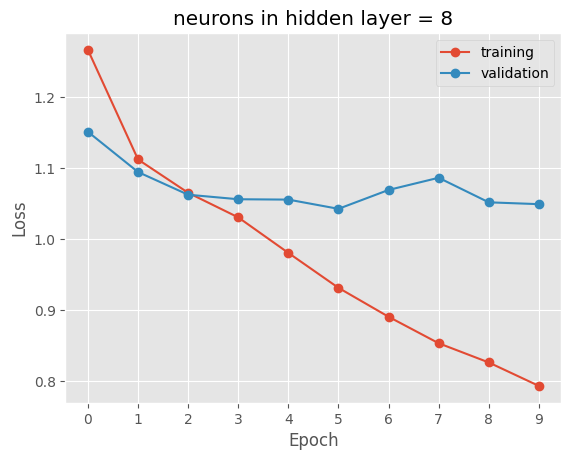

Neurons: 8 - Train Accuracy: 0.71, Validation Accuracy: 0.45


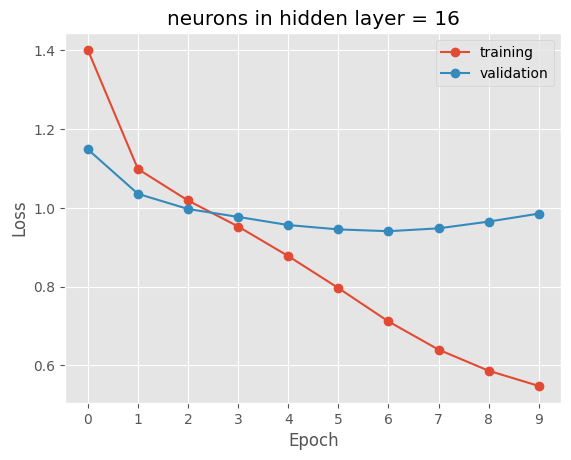

Neurons: 16 - Train Accuracy: 0.87, Validation Accuracy: 0.58


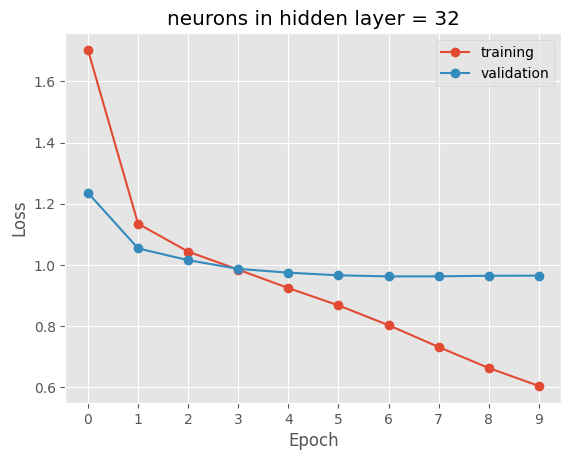

Neurons: 32 - Train Accuracy: 0.88, Validation Accuracy: 0.60


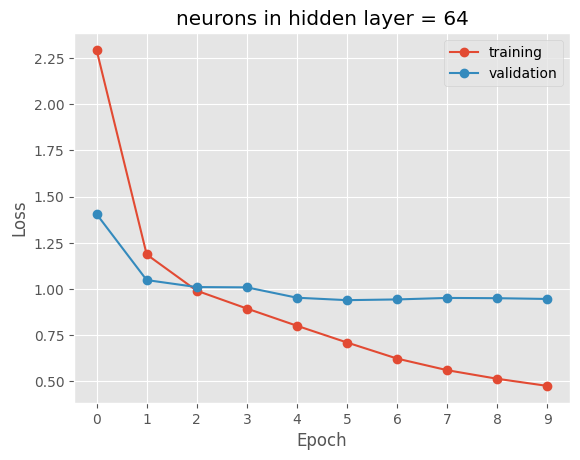

Neurons: 64 - Train Accuracy: 0.90, Validation Accuracy: 0.55


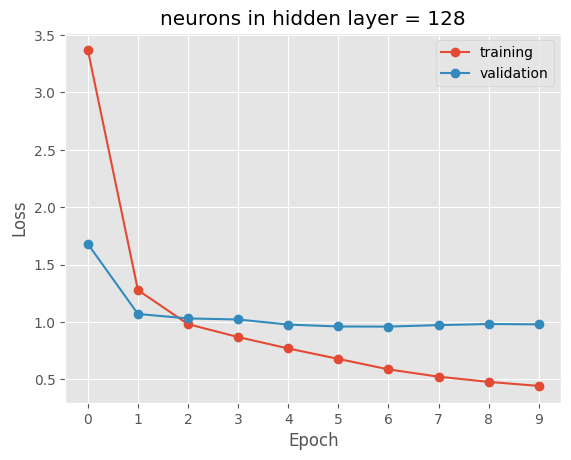

Neurons: 128 - Train Accuracy: 0.91, Validation Accuracy: 0.56


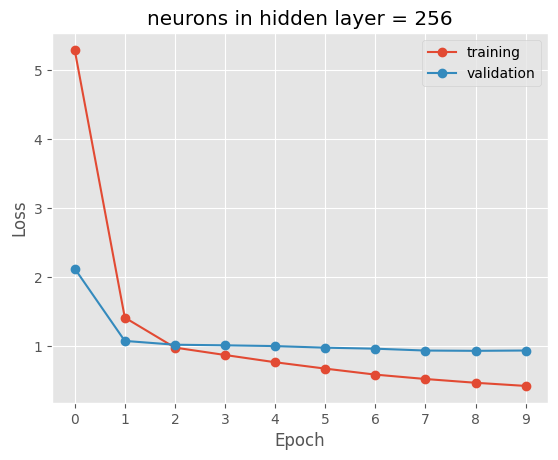

Neurons: 256 - Train Accuracy: 0.91, Validation Accuracy: 0.55


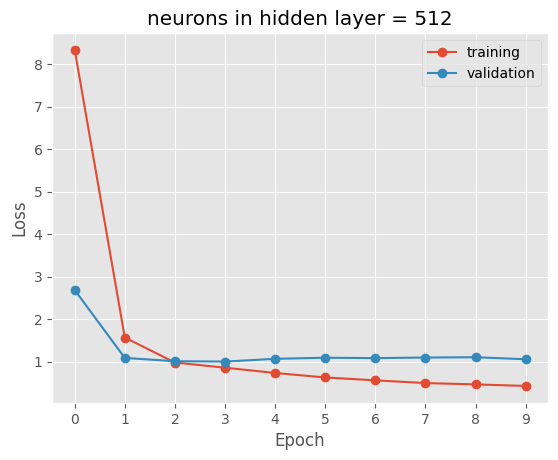

Neurons: 512 - Train Accuracy: 0.90, Validation Accuracy: 0.53


In [131]:
neuronsss = [8, 16, 32, 64, 128, 256, 512]
embedding_dim = 50
max_length = 40
epochs = 10
for neuron in neuronsss:
   model = build_model(vocab_size, embedding_dim, max_length, neuron, 0.02)
   history = model.fit(x_train_padded, y_train, validation_data=(x_val_padded, y_val), epochs=epochs, verbose=0)  
   history = pd.DataFrame(history.history)
   plot_history(history,neuron,'neurons in hidden layer')
   plt.show()
   train_accuracy = history['accuracy'].iloc[-1]
   val_accuracy = history['val_accuracy'].iloc[-1]
   print(f"Neurons: {neuron} - Train Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")


c:\Users\rupak\Videos\NLP\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


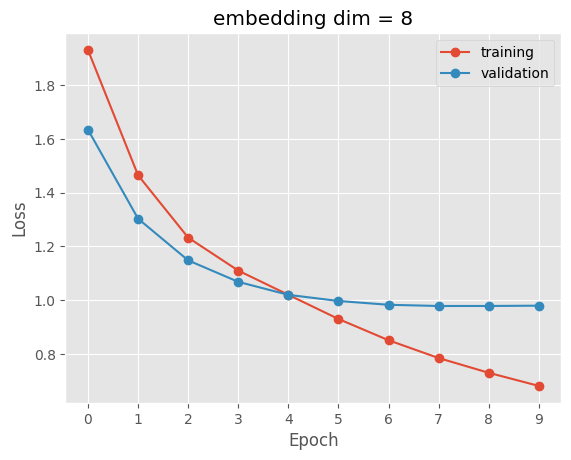

embedding dim: 8 - Train Accuracy: 0.81, Validation Accuracy: 0.59


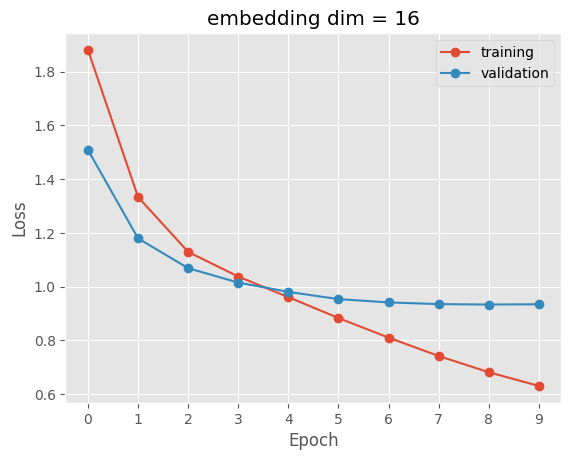

embedding dim: 16 - Train Accuracy: 0.86, Validation Accuracy: 0.66


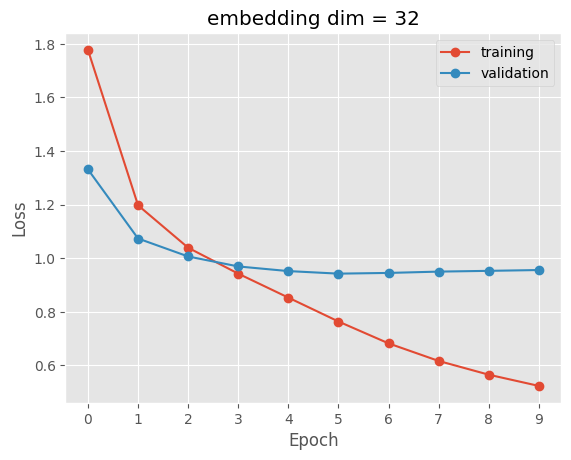

embedding dim: 32 - Train Accuracy: 0.89, Validation Accuracy: 0.62


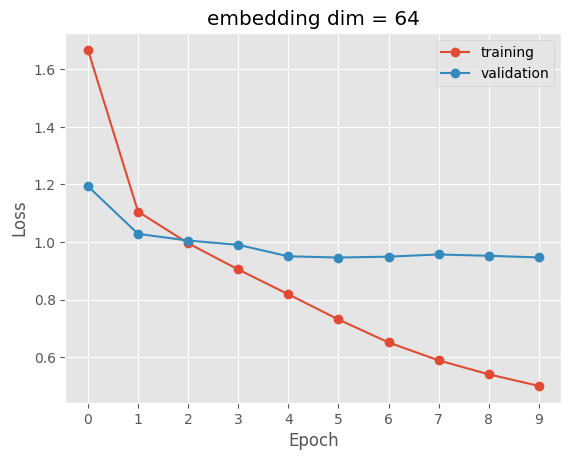

embedding dim: 64 - Train Accuracy: 0.90, Validation Accuracy: 0.58


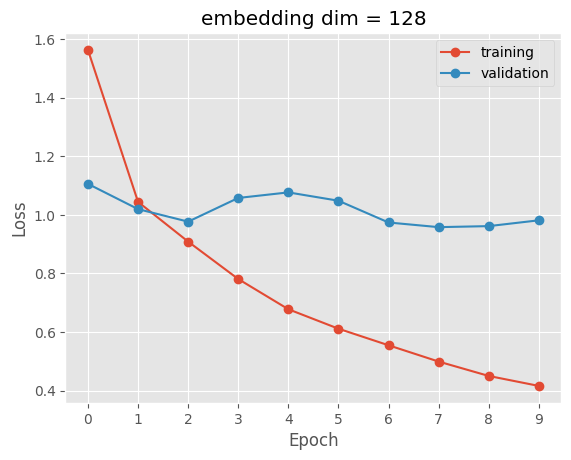

embedding dim: 128 - Train Accuracy: 0.91, Validation Accuracy: 0.61


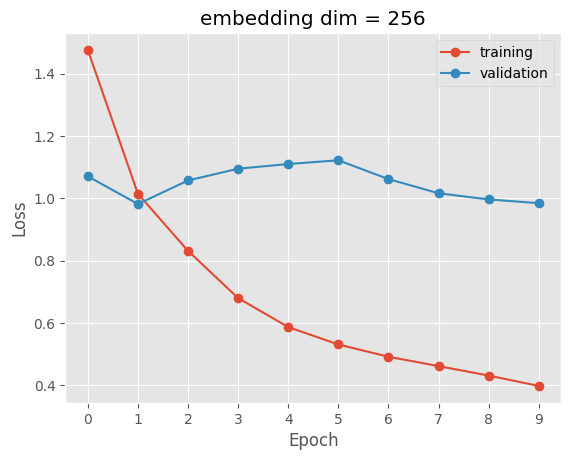

embedding dim: 256 - Train Accuracy: 0.91, Validation Accuracy: 0.56


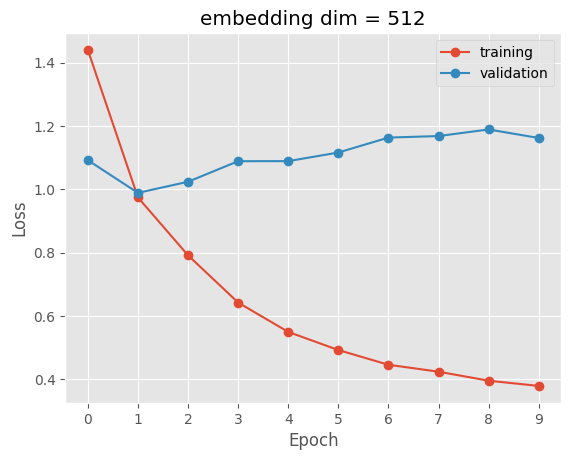

embedding dim: 512 - Train Accuracy: 0.91, Validation Accuracy: 0.57


In [134]:
emb_dim = [8, 16, 32, 64, 128, 256, 512]
for em in emb_dim:
    model = build_model(vocab_size, em, max_length,32, 0.02)
    history = model.fit(x_train_padded, y_train, validation_data=(x_val_padded, y_val), epochs=epochs, verbose=0)  
    history = pd.DataFrame(history.history)
    plot_history(history,em,'embedding dim')
    plt.show()
    train_accuracy = history['accuracy'].iloc[-1]
    val_accuracy = history['val_accuracy'].iloc[-1]
    print(f"embedding dim: {em} - Train Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")   